
# The A2 Big network with the filters from resolved_recon

Using TensorFlow backend.


sorting data by tag
filtering from 777150 events
307055
307055
scaling
DATA FOR .csv file:
pt_mean,pt_mean,pt_var,eta_mean,eta_var,phi_mean,phi_var
256.11149752858006,27916.901125095617,-0.0014992219260515209,1.0677470288555424,0.005690458419218211,3.294358926131252
164.86561670332696,14612.4925384995,-0.005093684343904041,1.1350676873768522,-0.003788391127691907,3.2521407108903593
71.18310004621601,2599.657714345263,-0.0007020347165962389,0.948686931082751,7.804521853106575e-05,2.712787621020359
150.26323922515658,22397.587779157522,-0.1506258762399934,1.5888654209540234,0.009877966251750877,2.7656118537515018
46.90408456008538,4780.308629897803,-0.14653969271759043,1.1602086184801772,0.001791804223719425,1.59342684619721
14.505335345705168,1098.7986691879564,-0.07913734843136995,0.5722631730012789,8.753826660580214e-07,0.6762211067418402
3.99437359294937,254.39851805473623,-0.03038944530818026,0.2053642550098717,0.0008098143287622032,0.2249127154012072
0.9509270640775735,54.457873515

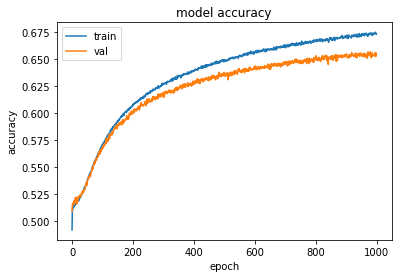

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.layers import Dense, Conv2D, Flatten, Dropout
import ptetaphi_nn
import tools
with open("filepath.txt", 'r') as f:
    filename = f.read()

s_table = tools.open_file(filename, sort_by="tag")

print('filtering from', len(s_table), 'events')

# we don't know how many real b exist
#nb4 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets exist

# we have exactly 3 b tags
nt3 = s_table.nbtags==3  # 3 b tags

events = s_table[nt3]

# and ensure that the 3 tags are actually correct
# this results in very little event loss
events = events[events.truth[:,0] == 1]
events = events[events.truth[:,1] == 1]
events = events[events.truth[:,2] == 1]
print(len(events))

cutoff = 10  # not many events have >10 jets
# "pad" = ensure all events have same length, cut off ends if needed
events = tools.pad(events, cutoff)

# then ensure require pt >= 40 and |eta| <= 2.5
pt_filter = events.resolved_lv.pt <= 40
events.resolved_lv.pt[pt_filter] = 0
events.resolved_lv.eta[pt_filter] = 0
events.resolved_lv.phi[pt_filter] = 0

eta_filter = (events.resolved_lv.eta >= -2.5) & (events.resolved_lv.eta >= 2.5)
events.resolved_lv.pt[eta_filter] = 0
events.resolved_lv.eta[eta_filter] = 0
events.resolved_lv.phi[eta_filter] = 0

print(len(events))

nn = ptetaphi_nn.PtEtaPhiNN(events)
# Feed forward NN

# create network
nn.model = Sequential([
    Dense(3*(cutoff-3), input_dim=3*(cutoff-3), kernel_initializer='normal', activation='relu'),
    Dense(700, activation='relu'),
    Dropout(0.1),
    Dense(500, activation='relu'),
    Dropout(0.1),
    Dense(300, activation='relu'),
    Dropout(0.1),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense( 50, activation='relu'),
    Dense(8, kernel_initializer='normal', activation='softmax')])
nn.model.compile(loss='categorical_crossentropy',
                 optimizer="adam", metrics=['acc'])
nn.model.summary()
nn.learn(epochs=1000)


using data given when this model was created


100%|██████████| 61411/61411 [00:00<00:00, 101872.19it/s]


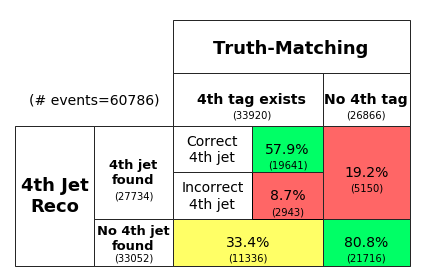

In [2]:
nn.evaluate(savename="same_filters")

In [3]:
# get the architecture as a json string
arch = nn.model.to_json()
# save the architecture string to a file somehow, the below will work
with open('architecture_same_filters.json', 'w') as arch_file:
    arch_file.write(arch)
# now save the weights as an HDF5 file
nn.model.save_weights('weights_same_filters.h5')